In [1]:
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency
import pandas as pd
import scipy.stats as ss
import seaborn as sns

Проект: вариант 4

 Задание 1
Представьте, что вы аналитик в компании, которая разрабатывает приложение для обработки и оформления фотографий в формате Stories (например, для дальнейшего экспорта в Instagram Stories). Был проведен A/B тест: тестовой группе предлагалась новая модель оплаты коллекций шаблонов, контрольной – старая механика. Ваша основная задача: проанализировать итоги эксперимента и решить, нужно ли выкатывать новую модель на остальных пользователей.

В ходе отчета обоснуйте выбор метрик, на которые вы обращаете внимание. Если различия есть, то объясните, с чем они могут быть связаны и являются ли значимыми.

Данные:

- active_users – информация о пользователях, которые посещали приложение во время эксперимента. 
- groups – разбивка пользователей на контрольную (А) и тестовую (В) группы. 
- purchases – данные о транзакциях (оплатах) пользователей приложения во время эксперимента 

In [2]:
users = pd.read_csv('Проект_4_active_users.csv', sep=',')
users.head()

,user_id,country,platform,sex
0,8029,Russia,ios,male
1,1735,Sweden,ios,male
2,7697,Russia,android,male
3,1421,Sweden,android,female
4,1704,Russia,ios,male


In [3]:
users.shape

(8341, 4)

In [4]:
users.nunique()

user_id     8341
country        2
platform       2
sex            2
dtype: int64

In [5]:
groups_AB = pd.read_csv('Проект_4_groups.csv', sep=',')
groups_AB.head()

,user_id,group
0,9149,B
1,9150,B
2,9151,A
3,9152,B
4,9153,B


In [6]:
groups_AB.shape

(74576, 2)

In [7]:
purchases = pd.read_csv('Проект_4_purchases.csv', sep=',')
purchases.head()

,user_id,revenue
0,4412,1000.0
1,9000,701.0
2,9001,700.0
3,9002,702.0
4,5790,1002.0


In [8]:
purchases.shape

(541, 2)

In [9]:
df = users.merge(groups_AB, on='user_id', how='left').merge(purchases, how='left', on='user_id')
df.head()

,user_id,country,platform,sex,group,revenue
0,8029,Russia,ios,male,B,NaN
1,1735,Sweden,ios,male,B,NaN
2,7697,Russia,android,male,B,NaN
3,1421,Sweden,android,female,B,NaN
4,1704,Russia,ios,male,B,NaN


In [10]:
# Заменим NaN на 0
df.revenue.fillna(0, inplace=True)

In [11]:
df.groupby('group', as_index=False).agg({'user_id': 'count'})

,group,user_id
0,A,1538
1,B,6803


Проведем небольшой эксплораторный анализ. Для этого посмотрим тип данных датафрейма, его размер, проверим отсутствующие значения и проверим основные статистические показатели.

In [12]:
df.shape

(8341, 6)

Датафрейм включает в себя 8341 строку и 6 столбцов (при этом количество пользователей совершивших оплату всего 541). Для проверки гипотезы об успешности новой модели оплаты, мы будем учитывать только активных пользователей (пользователей попавших под тестирование было 74576, но мы будем учитывать только активных пользователей.

In [13]:
df.dtypes

user_id       int64
country      object
platform     object
sex          object
group        object
revenue     float64
dtype: object

In [14]:
df.isna().sum()
# в датафрейме отсутствуют пропущенные значения

user_id     0
country     0
platform    0
sex         0
group       0
revenue     0
dtype: int64

In [15]:
df.describe().round(2)

,user_id,revenue
count,8341.00,8341.00
mean,4170.00,56.55
std,2407.98,311.35
min,0.00,0.00
25%,2085.00,0.00
50%,4170.00,0.00
75%,6255.00,0.00
max,8340.00,4660.00


Рассчитаем conversion rate (CR) для каждой из групп и посмотрим на уровень конверсии в покупку для каждой. Но перед этим рассчитаем число активных пользователей и пользователей, которые произвели оплату в разрезе групп:

In [16]:
users_A = df.query('group == "A"')['user_id'].count()
users_B = df.query('group == "B"')['user_id'].count()
users_A_pay = df.query("group == 'A' and revenue > 0")['user_id'].count()
users_B_pay = df.query("group == 'B' and revenue > 0")['user_id'].count()
print('group A', users_A)
print('group B', users_B)
print('group A pay', users_A_pay)
print('group B pay', users_B_pay)

group A 1538
group B 6803
group A pay 78
group B pay 314


In [17]:
CR_A = (users_A_pay / users_A * 100).round(2)
CR_B = (users_B_pay / users_B * 100).round(2)
print('CR group A', CR_A, 'CR group B', CR_B)

CR group A 5.07 CR group B 4.62


По итогам расчета видно, что уровень конверсии в тестовой группе ниже, чем в контрольной. Для того, чтобы понять так ли это, мы проведем статистическую оценку вероятности.
Поскольку конверсия имеет дискретное распределение вероятностей, вероятность которого равна либо 1, либо 0. Пользователь либо оплачивает покупку (1), либо не оплачивает (0).
Раз мы хотим проверить гипотезу по конверсии, которая является категориальной переменной, соответствующей дискретному распределению, мы рассчитаем chi2 и проверим нулевую гипотезу: распределение пользователей, которые платят и не платят в контрольной и тестовой группе не различается.

In [18]:
df['pay_notpay'] = df.revenue.apply(lambda x: 'pay' if x > 0 else 'notpay')

In [19]:
pd.crosstab(df.pay_notpay, df.group, values=df.user_id, aggfunc='count')

group,A,B
pay_notpay,,
notpay,1460,6489
pay,78,314


In [20]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.pay_notpay, df.group, values=df.user_id, aggfunc='count'))
stat, p

(0.48480826522557896, 0.48625240457231045)

In [21]:
"""prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')"""

"prob = 0.95\ncritical = chi2.ppf(prob, dof)\nif abs(stat) >= critical:\n    print('Отклоняем H0')\nelse:\n    print('Не отклоняем H0')"

In [22]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


Предположим, что основным фактором для принятия решения о применении новой модели на всех пользователях, будет являтся важный показатель выручки. Именно поэтому мы будет смотреть среднее значение revenue и проверять гипотезу групп А и В в разрезе выручки. 
Для начала рассчитаем среднее значение показателя revenue для контрольной и тестовой групп:

In [23]:
pd.crosstab(df.user_id, df.group, values=df.revenue,
            aggfunc='sum').mean()

group
A    47.853056
B    58.520212
dtype: float64

Далее стоит посмотреть на распределение выручки по группам.

In [24]:
df_rev = df.query('revenue > 0')
# исключим пользователей, которые не платили

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


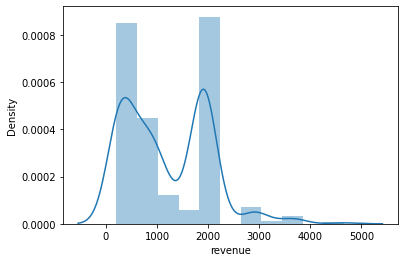

In [25]:
sns.distplot(df_rev.revenue)

Видно, что распредление несколько отклоняется от нормального и возможно присутствуют выбросы. Поэтому прежде чем проверять нулевую гипотезу, используя параметрические или непараметрические критерии оценки, нужно проверить нормальность распределения выборки, для этого построим гистограмму и рассчитаем критерий Шапиро-Уилка:

In [26]:
ss.shapiro(df_rev.query('group == "A"').revenue)
# p-value < 0.05, следовательно распределение не является нормальным

ShapiroResult(statistic=0.7358548641204834, pvalue=1.5417730980793465e-10)

In [27]:
ss.shapiro(df_rev.query('group == "B"').revenue)
# p-value < 0.05, следовательно распределение не является нормальным

ShapiroResult(statistic=0.8552882671356201, pvalue=1.665431681028873e-16)

Несмотря на результаты расчета критерия Шапиро-Уилка, учитывая большое количество наблюдений в выборке, результаты расчета критерия Стьюдента считаем действительными (https://stats.stackexchange.com/questions/9573/t-test-for-non-normal-when-n50)

In [28]:
ttest_ind(df_rev.query('group == "A"').revenue,
          df_rev.query('group == "B"').revenue)

Ttest_indResult(statistic=-3.134033935298925, pvalue=0.0018546337642145053)

Ввиду того, что p-value < 0.05, мы отклоняем нулевую гипотезу. К тому же среднее значение оплат в тестовой группе выше среднего значения в контрольной группе, что тоже говорит о возможной успешности новой модели.
Ввиду всего вышеуказанного можно было бы сказать, что эксперимент успешен и можно выкатывать новую модель на остальных пользователей. Но для того, чтобы не принять необдуманных решений, стоит рассмотреть выборку в разрезе имеющихся показателей и попробовать применить еще один непараметрический метод, поскольку распределение в выборке не является нормальным.
Используем непараметрический метод – U-критерий Манна-Уитни. Он проранжирует все данные revenue и рассчитает какой средний ранг оказался в первой группе и какой во второй. Этот критерий менее чувствителен к экстремальным отклонениям от нормальности и наличию выбросов.

In [29]:
RA = df_rev.query('country == "Russia" and group == "A"').revenue
RB = df_rev.query('country == "Russia" and group == "B"').revenue
SA = df_rev.query('country == "Sweden" and group == "A"').revenue 
SB = df_rev.query('country == "Sweden" and group == "B"').revenue
AA = df_rev.query('platform == "android" and group == "A"').revenue
AB = df_rev.query('platform == "android" and group == "B"').revenue
IA = df_rev.query('platform == "ios" and group == "A"').revenue
IB = df.query('platform == "ios" and group == "B"').revenue
FA = df_rev.query('sex == "female" and group == "A"').revenue
FB = df_rev.query('sex == "female" and group == "B"').revenue
MA = df_rev.query('sex == "male" and group == "A"').revenue
MB = df_rev.query('sex == "male" and group == "B"').revenue
print(mannwhitneyu(RA, RB))
print(mannwhitneyu(SA, SB))
print(mannwhitneyu(AA, AB))
print(mannwhitneyu(IA, IB))
print(mannwhitneyu(FA, FB))
print(mannwhitneyu(MA, MB))

MannwhitneyuResult(statistic=2925.5, pvalue=0.0014699816493472517)
MannwhitneyuResult(statistic=1577.5, pvalue=0.03958280081671394)
MannwhitneyuResult(statistic=2630.0, pvalue=0.04925014637316891)
MannwhitneyuResult(statistic=113862.5, pvalue=2.0159065098837945e-131)
MannwhitneyuResult(statistic=1841.0, pvalue=0.0008191912980826493)
MannwhitneyuResult(statistic=2663.0, pvalue=0.06326402745293058)


По итогам этого анализа можно увидеть более интересные результаты. Так, например, при группировке по половому признаку - очевидно, что нулевую гипотезу для мужчин мы отклонить не можем, соответственно и выкатывать на эту группу новую модель не имеет смысла.

Но стоит помнить о выбросах в выборке, поэтому лучшим решением будет запросить новую выборку, проверить ее на наличие выбросов и уже тогда принимать решение.

Ссылка на дашборд
https://public.tableau.com/app/profile/anastasia1983/viz/final_project4_a-poplavskaja-20_corr/Users_rev